In [68]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("max_columns", 50)

# Functions

In [69]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=sorted(classes), yticklabels=sorted(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig(title + '.png')
    return ax

# Data Exploration

In [70]:
database = pd.read_csv(r"../../data/metadata.csv")

database = database.drop(['img_id','lesion_id'], axis=1)

database.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_1516,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,False
1,PAT_46,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,True
2,PAT_1545,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,False
3,PAT_1989,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,False
4,PAT_684,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,True


In [71]:
database[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']] = database[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']].astype("bool")

database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   smoke                2298 non-null   bool   
 2   drink                2298 non-null   bool   
 3   background_father    1480 non-null   object 
 4   background_mother    1476 non-null   object 
 5   age                  2298 non-null   int64  
 6   pesticide            2298 non-null   bool   
 7   gender               1494 non-null   object 
 8   skin_cancer_history  2298 non-null   bool   
 9   cancer_history       2298 non-null   bool   
 10  has_piped_water      2298 non-null   bool   
 11  has_sewage_system    2298 non-null   bool   
 12  fitspatrick          1494 non-null   float64
 13  region               2298 non-null   object 
 14  diameter_1           1494 non-null   float64
 15  diameter_2           1494 non-null   f

In [72]:
database = database.drop_duplicates()

database.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 2297
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           1846 non-null   object 
 1   smoke                1846 non-null   bool   
 2   drink                1846 non-null   bool   
 3   background_father    1159 non-null   object 
 4   background_mother    1155 non-null   object 
 5   age                  1846 non-null   int64  
 6   pesticide            1846 non-null   bool   
 7   gender               1169 non-null   object 
 8   skin_cancer_history  1846 non-null   bool   
 9   cancer_history       1846 non-null   bool   
 10  has_piped_water      1846 non-null   bool   
 11  has_sewage_system    1846 non-null   bool   
 12  fitspatrick          1169 non-null   float64
 13  region               1846 non-null   object 
 14  diameter_1           1169 non-null   float64
 15  diameter_2           1169 non-null   f

In [73]:
df_n = database.copy()
df_n = df_n.fillna("n/a")
df_n.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_1516,True,True,n/a,n/a,8,True,n/a,True,True,True,True,n/a,ARM,n/a,n/a,NEV,True,True,True,True,True,True,False
1,PAT_46,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,True,True,True,True,True
2,PAT_1545,True,True,n/a,n/a,77,True,n/a,True,True,True,True,n/a,FACE,n/a,n/a,ACK,True,True,True,True,True,True,False
3,PAT_1989,True,True,n/a,n/a,75,True,n/a,True,True,True,True,n/a,HAND,n/a,n/a,ACK,True,True,True,True,True,True,False
4,PAT_684,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,True,True,True,True,True


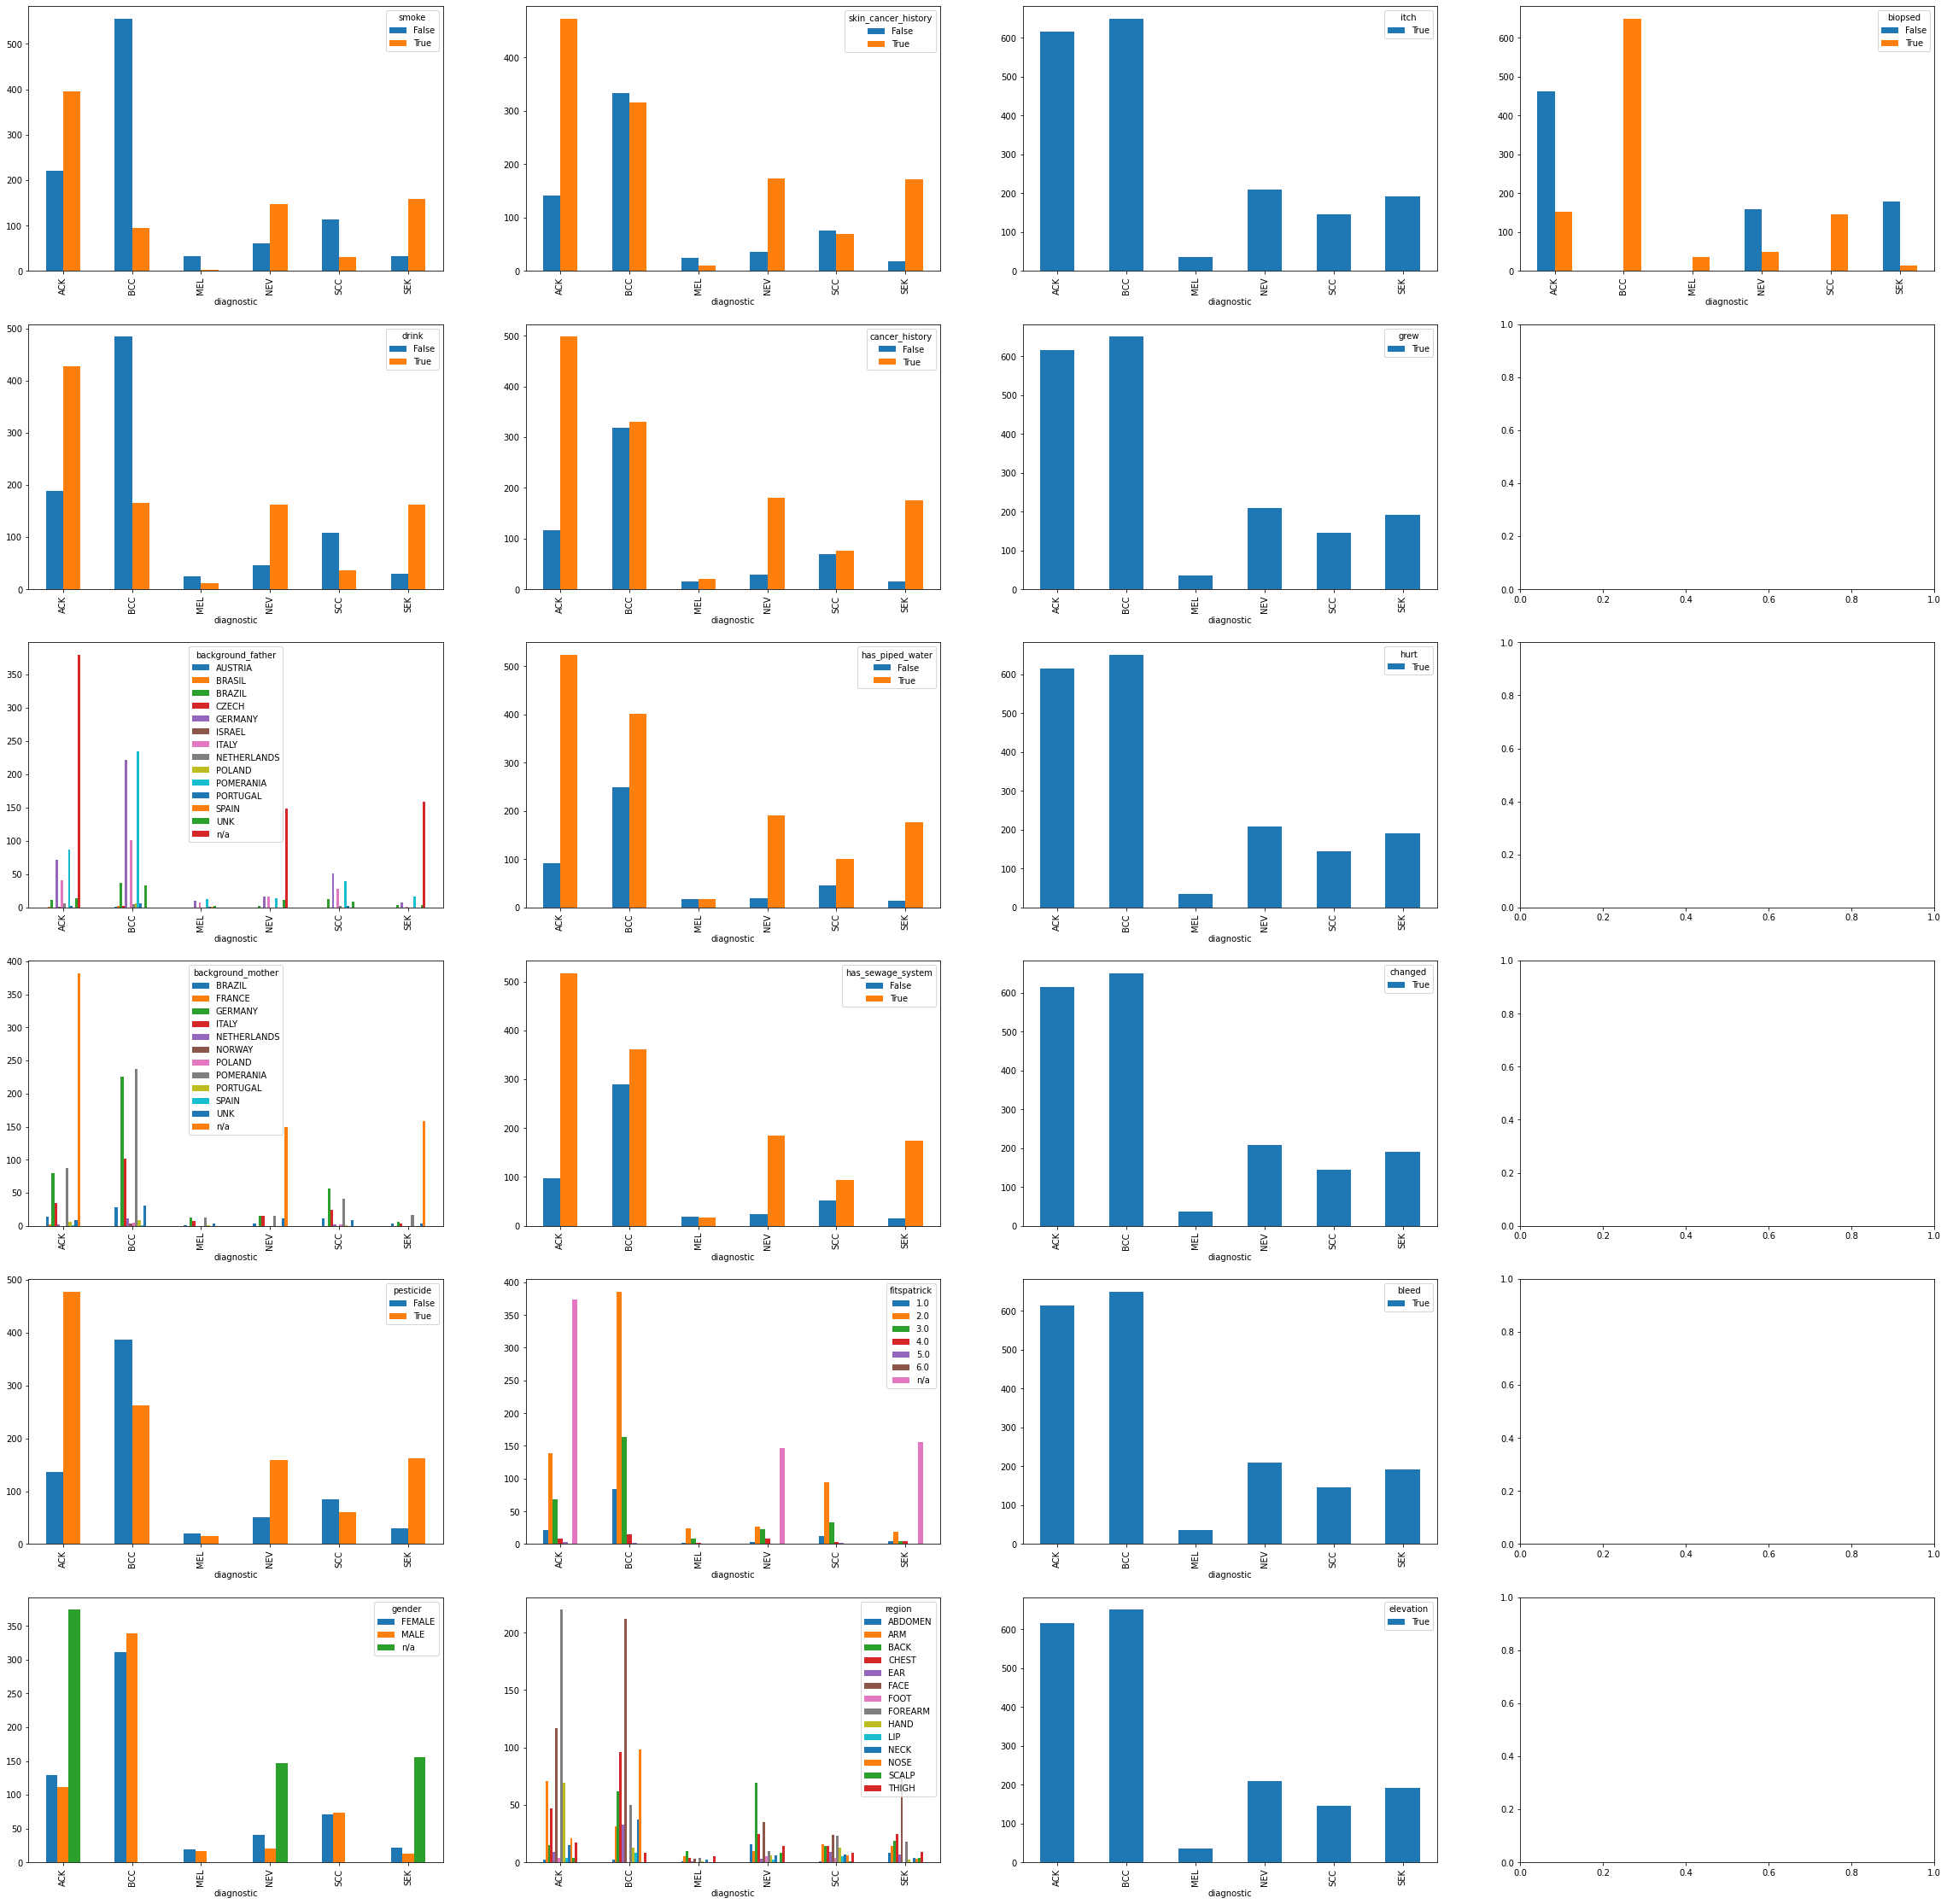

In [74]:
columns = ['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']

fig, axes = plt.subplots(6, 4, figsize=(40,40))

i=-1
i2=0

for e in columns:
    i+=1
    if int(i % 6) == 0 and i !=0:
        i2+=1
        i=0
    ct = pd.crosstab(index = df_n['diagnostic'], columns = df_n[e])
    
    ct.plot(kind = "bar",ax=axes[i,i2])

In [75]:
df = database.copy()

df = df.sort_values('diameter_1', ascending=False).groupby('patient_id').first().reset_index()

df.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_10,True,False,GERMANY,GERMANY,69,False,MALE,False,False,True,False,1.0,ARM,13.0,9.0,SCC,True,True,True,True,True,True,True
1,PAT_100,False,False,POMERANIA,POMERANIA,14,False,MALE,False,True,False,False,1.0,FACE,7.0,3.0,NEV,True,True,True,True,True,True,True
2,PAT_1000,True,True,None,None,65,True,None,True,True,True,True,NaN,EAR,NaN,NaN,SEK,True,True,True,True,True,True,False
3,PAT_1006,True,True,None,None,63,True,None,True,True,True,True,NaN,FOREARM,NaN,NaN,ACK,True,True,True,True,True,True,False
4,PAT_1008,True,True,None,None,64,True,None,True,True,True,True,NaN,FACE,NaN,NaN,SEK,True,True,True,True,True,True,False


In [76]:
selected_columns = ['smoke', 'drink', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'age','region','pesticide','diagnostic']

df = df[selected_columns].copy()

df['region'] = df['region'].apply(lambda x: 'OUTROS' if x in ['THIGH','LIP','FOOT','ABDOMEN','SCALP'] else x)

df['is_cancer'] = df['diagnostic'].apply(lambda x: 0 if x in ['ACK','NEV','SEK'] else 1)

df.head()

,smoke,drink,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,age,region,pesticide,diagnostic,is_cancer
0,True,False,False,False,True,False,69,ARM,False,SCC,1
1,False,False,False,True,False,False,14,FACE,False,NEV,0
2,True,True,True,True,True,True,65,EAR,True,SEK,0
3,True,True,True,True,True,True,63,FOREARM,True,ACK,0
4,True,True,True,True,True,True,64,FACE,True,SEK,0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   smoke                1373 non-null   bool  
 1   drink                1373 non-null   bool  
 2   skin_cancer_history  1373 non-null   bool  
 3   cancer_history       1373 non-null   bool  
 4   has_piped_water      1373 non-null   bool  
 5   has_sewage_system    1373 non-null   bool  
 6   age                  1373 non-null   int64 
 7   region               1373 non-null   object
 8   pesticide            1373 non-null   bool  
 9   diagnostic           1373 non-null   object
 10  is_cancer            1373 non-null   int64 
dtypes: bool(7), int64(2), object(2)
memory usage: 52.4+ KB


In [78]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer((OneHotEncoder(categories='auto'), ['region']), remainder='passthrough')

transformed = transformer.fit_transform(df)

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed_df.head().transpose()

,0,1,2,3,4
onehotencoder__x0_ARM,1.0,0.0,0.0,0.0,0.0
onehotencoder__x0_BACK,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_CHEST,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_EAR,0.0,0.0,1.0,0.0,0.0
onehotencoder__x0_FACE,0.0,1.0,0.0,0.0,1.0
onehotencoder__x0_FOREARM,0.0,0.0,0.0,1.0,0.0
onehotencoder__x0_HAND,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_NECK,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_NOSE,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_OUTROS,0.0,0.0,0.0,0.0,0.0


# Train Test Split

In [79]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['diagnostic'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['is_cancer'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)
y_train_bin = y_train_bin.astype(np.float64)
y_test_bin = y_test_bin.astype(np.float64)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")
print(f"{x_train_bin.shape=}")
print(f"{x_test_bin.shape=}")
print(f"{y_train_bin.shape=}")
print(f"{y_test_bin.shape=}")

x_train.shape=(1098, 18)
x_test.shape=(275, 18)
y_train.shape=(1098,)
y_test.shape=(275,)
x_train_bin.shape=(1098, 18)
x_test_bin.shape=(275, 18)
y_train_bin.shape=(1098,)
y_test_bin.shape=(275,)


# Predict

In [80]:
def eval_model(model, x_test, y_test, title, *, classes=None):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    if classes:
        classes_list = classes
    else:
        classes_list = list(set(y_test))
    plot_confusion_matrix(y_test, y_pred, classes_list, normalize=True, title=title, save_to_file=True)

Text(0, 0.5, '')

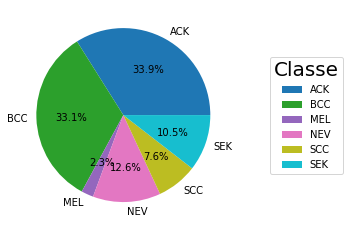

In [81]:
def pct_format(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%".format(pct, absolute)

cnts = (y_train.value_counts()+y_test.value_counts())
ax = cnts.plot(kind="pie",cmap="tab10", autopct=lambda pct: pct_format(pct, cnts))
ax.legend(title='Classe',title_fontsize=20,loc='center left', bbox_to_anchor=(1.15, 0.5))
ax.set_ylabel("")

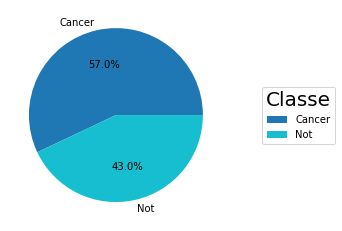

In [82]:
cnts = (y_train_bin.value_counts()+y_test_bin.value_counts())
cnts = cnts.set_axis(["Cancer", "Not"])
ax = cnts.plot(kind="pie",cmap="tab10", autopct=lambda pct: pct_format(pct, cnts))
ax.legend(title='Classe',title_fontsize=20,loc='center left', bbox_to_anchor=(1.15, 0.5))
ax.set_ylabel("");

# Logistic Regression

Multinomial Log Reg
Model accuracy on train: 0.6302367941712205
Model accuracy on test: 0.6509794553272813

Binary Log Reg
Model accuracy on train: 0.7914389799635702
Model accuracy on test: 0.8254100971492276


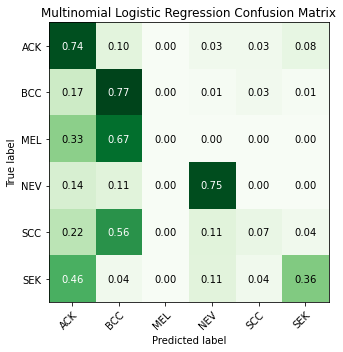

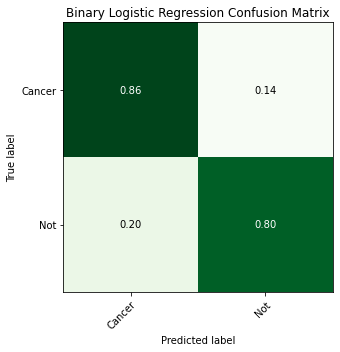

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import metrics

print("Multinomial Log Reg")
log_reg = LogisticRegression(random_state=RANDOM_SEED, max_iter=1e5)
log_reg.fit(x_train, y_train)
eval_model(log_reg, x_test, y_test, title="Multinomial Logistic Regression Confusion Matrix")
tr = cross_val_score(log_reg, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(log_reg, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

print("\nBinary Log Reg")
log_reg_bin = LogisticRegression(random_state=RANDOM_SEED, max_iter=1e5)
log_reg_bin.fit(x_train_bin, y_train_bin)
eval_model(log_reg_bin, x_test_bin, y_test_bin, title="Binary Logistic Regression Confusion Matrix", classes=["Not", "Cancer"])
tr = cross_val_score(log_reg_bin, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(log_reg_bin, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Random Forest Classifier

Multinomial RFC
Model accuracy on train: 0.5728597449908926
Model accuracy on test: 0.5926501035196687

Binary RFC
Model accuracy on train: 0.8242258652094718
Model accuracy on test: 0.8471492275840102


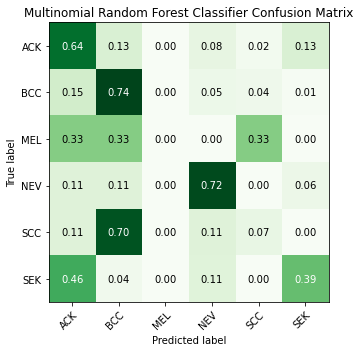

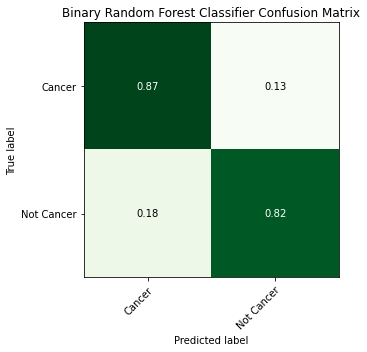

In [84]:
from sklearn.ensemble import RandomForestClassifier

print("Multinomial RFC")
rfc_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf.fit(x_train, y_train)
eval_model(rfc_clf, x_test, y_test, title="Multinomial Random Forest Classifier Confusion Matrix")
tr = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

print("\nBinary RFC")
rfc_clf_bin = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf_bin.fit(x_train_bin, y_train_bin)
eval_model(rfc_clf_bin, x_test_bin, y_test_bin, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not Cancer", "Cancer"])
tr = cross_val_score(rfc_clf, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# XGBoost

Multinomial XGBoost
Model accuracy on train: 0.5655737704918032
Model accuracy on test: 0.567287784679089

Binary XGBoost
Model accuracy on train: 0.8005464480874317
Model accuracy on test: 0.8218267240006369


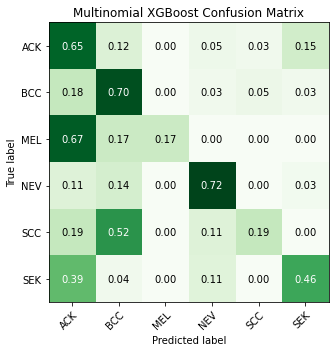

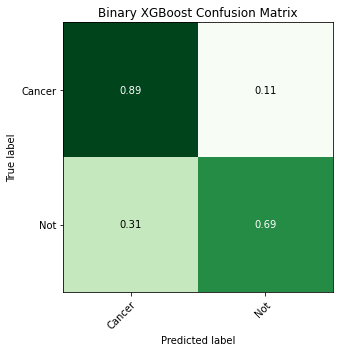

In [85]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder

xgb_encoder = OrdinalEncoder()
x_train_xgb = x_train.astype(np.float64)
y_train_xgb = xgb_encoder.fit_transform(y_train.to_numpy().reshape(-1,1))
x_test_xgb = x_test.astype(np.float64)
y_test_xgb = xgb_encoder.transform(y_test.to_numpy().reshape(-1,1))


print("Multinomial XGBoost")
sgb_clf = XGBClassifier(random_state=RANDOM_SEED, n_estimators=110, eval_metric='auc')
sgb_clf.fit(x_train_xgb, y_train_xgb)
y_pred = sgb_clf.predict(x_test_xgb)
y_pred_proba = sgb_clf.predict_proba(x_test_xgb)[:,1]
plot_confusion_matrix(xgb_encoder.inverse_transform(y_test_xgb), xgb_encoder.inverse_transform(y_pred.reshape(-1,1)), sorted(list(set(y_test))), normalize=True, title="Multinomial XGBoost Confusion Matrix", save_to_file=True);
tr = cross_val_score(sgb_clf, x_train_xgb, y_train_xgb, cv=3, scoring='accuracy')
tst = cross_val_score(sgb_clf, x_test_xgb, y_test_xgb, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

x_train_xgb_bin = x_train_bin.astype(np.float64)
y_train_xgb_bin = xgb_encoder.fit_transform(y_train_bin.to_numpy().reshape(-1,1))
x_test_xgb_bin = x_test_bin.astype(np.float64)
y_test_xgb_bin = xgb_encoder.fit_transform(y_test_bin.to_numpy().reshape(-1,1))

print("\nBinary XGBoost")
sgb_clf_bin = XGBClassifier(random_state=RANDOM_SEED, n_estimators=110, eval_metric='auc')
sgb_clf_bin.fit(x_train_xgb_bin, y_train_bin.to_numpy().reshape(-1,1)) 
y_pred = sgb_clf_bin.predict(x_test_xgb_bin)
y_pred_proba = sgb_clf_bin.predict_proba(x_test_xgb_bin)[:,1]
plot_confusion_matrix(y_test_xgb_bin, y_pred.reshape(-1,1), ["Not", "Cancer"], normalize=True, title="Binary XGBoost Confusion Matrix", save_to_file=True);
tr = cross_val_score(sgb_clf_bin, x_train_xgb_bin, y_train_xgb_bin, cv=3, scoring='accuracy')
tst = cross_val_score(sgb_clf_bin, x_test_xgb_bin, y_test_xgb_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Feature Importances

In [86]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [h for h in np.arange(50,250,25)],
    'max_features': [k for k in np.arange(1,df.shape[1])]
}
grid = GridSearchCV(rfc_clf_bin,
                    params,
                    cv = 4,
                    scoring='accuracy',
                    return_train_score=True,
                    n_jobs=-1
)

grid.fit(x_train,y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200,
                                          225]},
             return_train_score=True, scoring='accuracy')

In [87]:
feature_importances = grid.best_estimator_.feature_importances_
importance_list = sorted(zip(feature_importances, x_train.columns.values), reverse=True)
importance_list

[(0.41340669173830036, 'age'),
 (0.10848588950384475, 'smoke'),
 (0.06307341505075953, 'drink'),
 (0.049269508091808134, 'skin_cancer_history'),
 (0.04833608712966853, 'cancer_history'),
 (0.04631346437019466, 'pesticide'),
 (0.035528990577407035, 'has_sewage_system'),
 (0.03449801828847836, 'onehotencoder__x0_OUTROS'),
 (0.033405957805392045, 'onehotencoder__x0_FOREARM'),
 (0.029262709832817174, 'onehotencoder__x0_BACK'),
 (0.027181551276403138, 'has_piped_water'),
 (0.02384854883255085, 'onehotencoder__x0_HAND'),
 (0.022392349544521534, 'onehotencoder__x0_FACE'),
 (0.018985002991006517, 'onehotencoder__x0_ARM'),
 (0.01672771576031111, 'onehotencoder__x0_CHEST'),
 (0.01078226029299768, 'onehotencoder__x0_EAR'),
 (0.010680012560533619, 'onehotencoder__x0_NOSE'),
 (0.007821826353005113, 'onehotencoder__x0_NECK')]

In [94]:
transformed_df = df.drop(['region', 'has_sewage_system','has_piped_water'], axis = 1)

transformed_df.head()


,smoke,drink,skin_cancer_history,cancer_history,age,pesticide,diagnostic,is_cancer
0,True,False,False,False,69,False,SCC,1
1,False,False,False,True,14,False,NEV,0
2,True,True,True,True,65,True,SEK,0
3,True,True,True,True,63,True,ACK,0
4,True,True,True,True,64,True,SEK,0


In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['diagnostic'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['is_cancer'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)
y_train_bin = y_train_bin.astype(np.float64)
y_test_bin = y_test_bin.astype(np.float64)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")
print(f"{x_train_bin.shape=}")
print(f"{x_test_bin.shape=}")
print(f"{y_train_bin.shape=}")
print(f"{y_test_bin.shape=}")

x_train.shape=(1098, 6)
x_test.shape=(275, 6)
y_train.shape=(1098,)
y_test.shape=(275,)
x_train_bin.shape=(1098, 6)
x_test_bin.shape=(275, 6)
y_train_bin.shape=(1098,)
y_test_bin.shape=(275,)


Multinomial RFC
Model accuracy on train: 0.48269581056466304
Model accuracy on test: 0.5344401974836758

Binary RFC
Model accuracy on train: 0.7914389799635702
Model accuracy on test: 0.8326166587036153


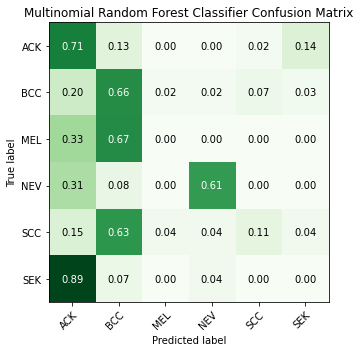

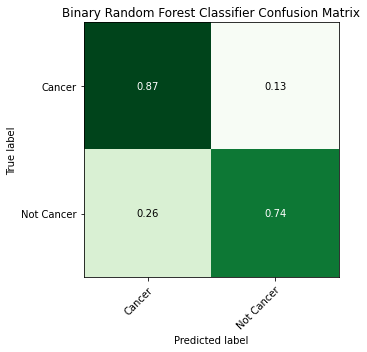

In [96]:
from sklearn.ensemble import RandomForestClassifier

print("Multinomial RFC")
rfc_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf.fit(x_train, y_train)
eval_model(rfc_clf, x_test, y_test, title="Multinomial Random Forest Classifier Confusion Matrix")
tr = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

print("\nBinary RFC")
rfc_clf_bin = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf_bin.fit(x_train_bin, y_train_bin)
eval_model(rfc_clf_bin, x_test_bin, y_test_bin, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not Cancer", "Cancer"])
tr = cross_val_score(rfc_clf, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

In [97]:
feature_importances = rfc_clf_bin.feature_importances_
importance_list = sorted(zip(feature_importances, x_train.columns.values), reverse=True)
importance_list

[(0.36211434973401946, 'age'),
 (0.26997357376421915, 'smoke'),
 (0.12361488944716703, 'drink'),
 (0.09817064490274242, 'skin_cancer_history'),
 (0.07488069942189318, 'pesticide'),
 (0.07124584272995871, 'cancer_history')]